<a href="https://www.kaggle.com/code/piotrpowroznik/beats-per-minute-lightgbm-pipeline?scriptVersionId=262017704" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train_data = pd.read_csv("/kaggle/input/playground-series-s5e9/train.csv")

In [3]:
train_data.head(5)

,id,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,BeatsPerMinute
0,0,0.603610,-7.636942,0.023500,0.000005,0.000001,0.051385,0.409866,290715.6450,0.826267,147.53020
1,1,0.639451,-16.267598,0.071520,0.444929,0.349414,0.170522,0.651010,164519.5174,0.145400,136.15963
2,2,0.514538,-15.953575,0.110715,0.173699,0.453814,0.029576,0.423865,174495.5667,0.624667,55.31989
3,3,0.734463,-1.357000,0.052965,0.001651,0.159717,0.086366,0.278745,225567.4651,0.487467,147.91212
4,4,0.532968,-13.056437,0.023500,0.068687,0.000001,0.331345,0.477769,213960.6789,0.947333,89.58511


In [4]:
print("Number of rows: ", train_data.shape[0])
print("Number of columns: ", train_data.shape[1])


Number of rows:  524164
Number of columns:  11


In [5]:
NaN_values_count = train_data.isna().sum()
print(NaN_values_count)

id                           0
RhythmScore                  0
AudioLoudness                0
VocalContent                 0
AcousticQuality              0
InstrumentalScore            0
LivePerformanceLikelihood    0
MoodScore                    0
TrackDurationMs              0
Energy                       0
BeatsPerMinute               0
dtype: int64


In [6]:
columns_datatypes = train_data.dtypes
print(columns_datatypes)

id                             int64
RhythmScore                  float64
AudioLoudness                float64
VocalContent                 float64
AcousticQuality              float64
InstrumentalScore            float64
LivePerformanceLikelihood    float64
MoodScore                    float64
TrackDurationMs              float64
Energy                       float64
BeatsPerMinute               float64
dtype: object


# Correlation

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


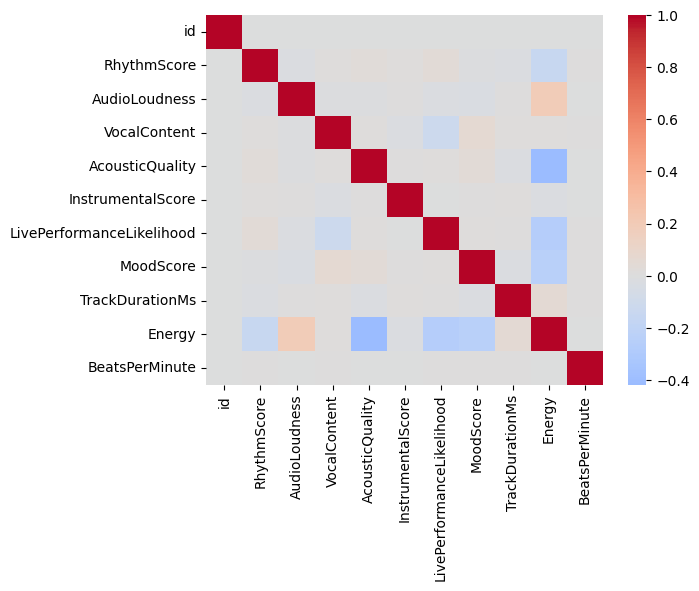

In [7]:
ax = sns.heatmap(train_data.corr(), annot=False, cmap='coolwarm', center=0)

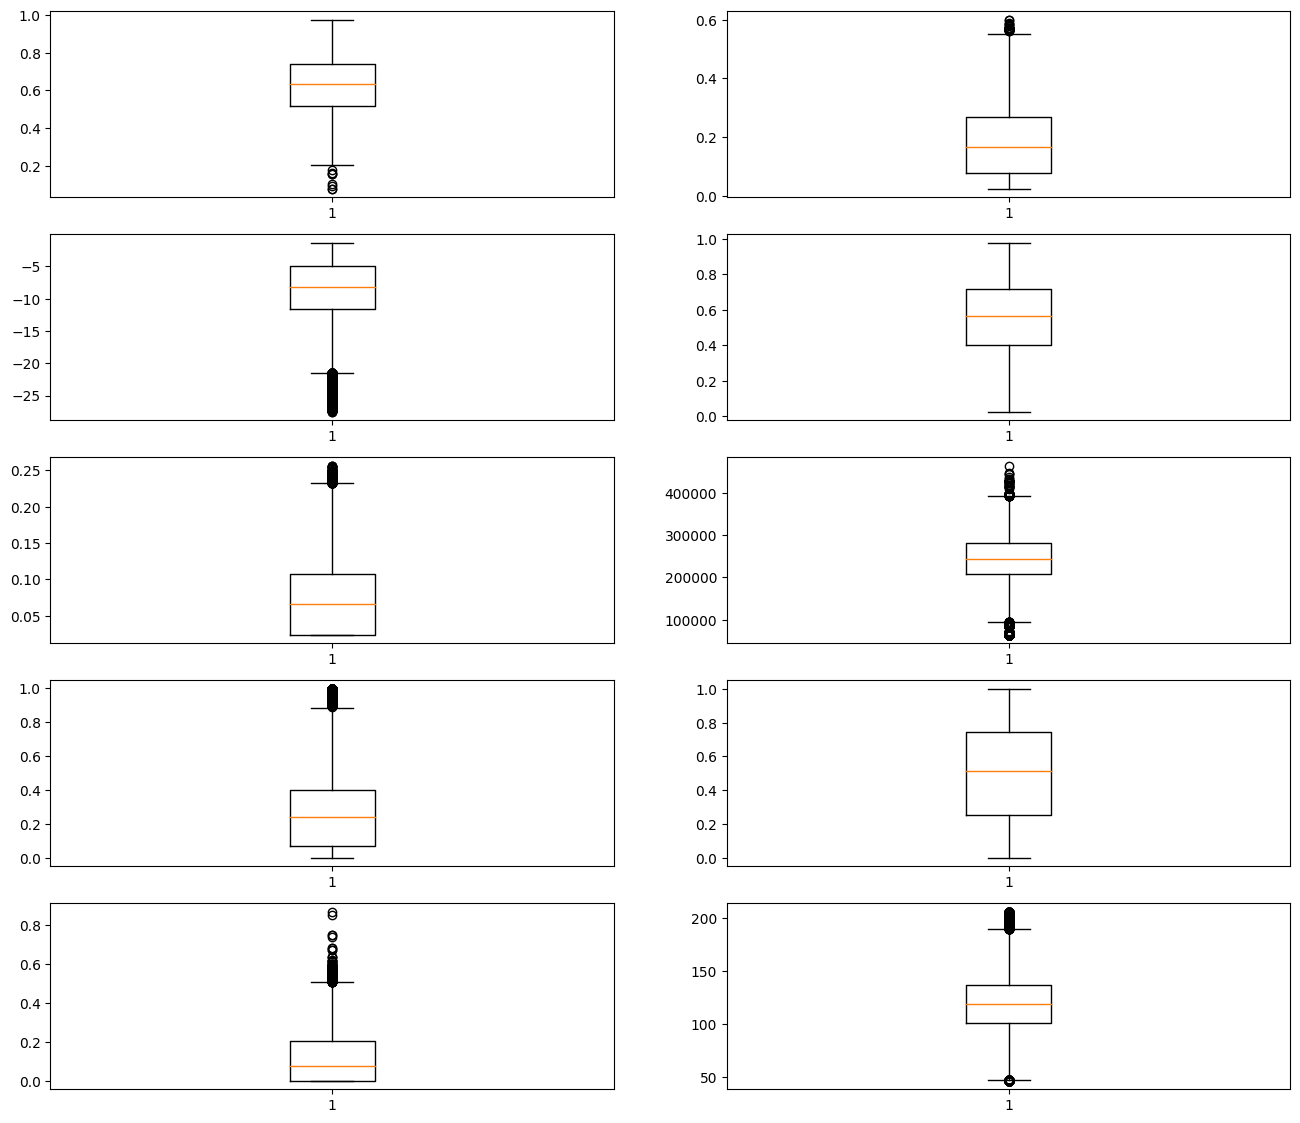

In [8]:
fig, axs = plt.subplots(5, 2, figsize=(16, 14))

axs[0][0].boxplot(train_data["RhythmScore"])
axs[1][0].boxplot(train_data["AudioLoudness"])
axs[2][0].boxplot(train_data["VocalContent"])
axs[3][0].boxplot(train_data["AcousticQuality"])
axs[4][0].boxplot(train_data["InstrumentalScore"])

axs[0][1].boxplot(train_data["LivePerformanceLikelihood"])
axs[1][1].boxplot(train_data["MoodScore"])
axs[2][1].boxplot(train_data["TrackDurationMs"])
axs[3][1].boxplot(train_data["Energy"])
axs[4][1].boxplot(train_data["BeatsPerMinute"])

plt.show()

In [9]:
min_vals = []
max_vals = []

for col in train_data.columns:
    min_vals.append(train_data[col].min())
    max_vals.append(train_data[col].max())
    
values_range = pd.DataFrame({"col_name": train_data.columns, "min": min_vals, "max": max_vals})

values_range

,col_name,min,max
0,id,0.000000,524163.000000
1,RhythmScore,0.076900,0.975000
2,AudioLoudness,-27.509725,-1.357000
3,VocalContent,0.023500,0.256401
4,AcousticQuality,0.000005,0.995000
5,InstrumentalScore,0.000001,0.869258
6,LivePerformanceLikelihood,0.024300,0.599924
7,MoodScore,0.025600,0.978000
8,TrackDurationMs,63973.000000,464723.228100
9,Energy,0.000067,1.000000


# Split Data & Remove Outliers

In [10]:
def remove_outliers(df):
    for column in df.columns:        
        q_low = df[column].quantile(0.01)
        q_hi  = df[column].quantile(0.99)
        
        df = df[(df[column] <= q_hi) & (df[column] >= q_low)]

    return df

In [11]:
from sklearn.model_selection import train_test_split
from scipy import stats

train_data = pd.read_csv("/kaggle/input/playground-series-s5e9/train.csv")
# Drop outliers
train_data = remove_outliers(train_data)

y = train_data["BeatsPerMinute"]
X = train_data.drop(["BeatsPerMinute", "id"], axis=1)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, train_size=0.2, random_state=43)


X_test_full = pd.read_csv("/kaggle/input/playground-series-s5e9/test.csv")
X_test = X_test_full.drop(["id"], axis=1)


# Pipeline

In [12]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

transformer = ColumnTransformer(
    transformers=[
        ('numerical', StandardScaler(), X.select_dtypes(include=['float64', 'int64']).columns),
    ]
)

transformer

ColumnTransformer(transformers=[('numerical', StandardScaler(),
                                 Index(['RhythmScore', 'AudioLoudness', 'VocalContent', 'AcousticQuality',
       'InstrumentalScore', 'LivePerformanceLikelihood', 'MoodScore',
       'TrackDurationMs', 'Energy'],
      dtype='object'))])

In [13]:
from lightgbm import LGBMRegressor

model = LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=6,
    num_leaves=64,
    feature_fraction=0.8,
    bagging_fraction=0.8,
    bagging_freq=9,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

In [14]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline(
    steps=[
        ('transformer', transformer),
        ('lgbm_classifier', model)
    ]
)
pipeline

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('numerical', StandardScaler(),
                                                  Index(['RhythmScore', 'AudioLoudness', 'VocalContent', 'AcousticQuality',
       'InstrumentalScore', 'LivePerformanceLikelihood', 'MoodScore',
       'TrackDurationMs', 'Energy'],
      dtype='object'))])),
                ('lgbm_classifier',
                 LGBMRegressor(bagging_fraction=0.8, bagging_freq=9,
                               feature_fraction=0.8, learning_rate=0.01,
                               max_depth=6, n_estimators=1000, n_jobs=-1,
                               num_leaves=64, random_state=42, verbose=-1))])

In [15]:
pipeline.fit(X_train,y_train)
pred = pipeline.predict(X_valid)


In [16]:
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(y_valid, pred))
print("RMSE:", rmse)

RMSE: 24.958284409243817


In [17]:
pred = pipeline.predict(X_test)

In [18]:
submission = pd.DataFrame({
    "id": X_test_full["id"],
    "BeatsPerMinute": pred
})

submission.to_csv("submission.csv", index=False)
submission.head(5)

,id,BeatsPerMinute
0,524164,116.787500
1,524165,120.244804
2,524166,117.965326
3,524167,118.321079
4,524168,119.440664
